Generating the dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from tqdm import tqdm

In [98]:
def generateData(nData : int): 
    x = np.linspace(-1, 1, nData)
    y = 1 / (1 + 25*np.pow(x, 2)) + np.random.normal(0, 1)

    return train_test_split(normalize(x.reshape(-1, 1), axis=0, norm='max'), y)

In [177]:
def OLS_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

def featureMat(x : np.array, p : int, noIntercept : bool = False) -> np.array:
    return x[:, None] ** np.arange(int(noIntercept), p+1)

def MSE(target : np.array, pred : np.array) -> int:
    return np.average(np.pow(target - pred, 2))

def R2(target : np.array, pred : np.array) -> int:
    ybar = np.average(target)
    denom = np.sum(np.pow(target - ybar, 2))

    return 1 - np.sum(np.pow(target - pred, 2)) / denom

In [172]:
def generateFitOLS(xTrain : np.array, yTrain : np.array, degree : int) -> np.array:
    X = featureMat(xTrain, degree)
    return OLS_parameters(X, yTrain)

def testFit(xTest : np.array, yTest : np.array, beta : np.array) -> int:
    X = featureMat(xTest, len(beta)-1)
    pred = X @ beta
    return MSE(yTest, pred), R2(yTest, pred)

[ 0.51561871  0.19205979  0.53132604  0.54477527  0.41046761  0.46641269
  0.11072165  0.49869     0.34889959  0.54546854  0.05147116 -0.04392584
  0.53707677  0.28189753 -0.07720251  0.54197802  0.53383716  0.319085
  0.52096232  0.38557847  0.15244272  0.17878675  0.30338871  0.39828604
  0.43668173]
[ 0.51072355  0.18989854  0.53468912  0.54388333  0.40305921  0.47308695
  0.11237253  0.50433457  0.3555275   0.54554995  0.04622211 -0.0551862
  0.53429087  0.27654703 -0.06404027  0.54012516  0.53060002  0.32513083
  0.51645576  0.37827224  0.15203844  0.18008003  0.30905935  0.39090593
  0.44378248]
[0.60647947 0.03311518 0.66029049 0.70238198 0.32421904 0.46987269
 0.02577674 0.56049307 0.21085188 0.70517262 0.05895349 0.16374774
 0.67598109 0.10490889 0.21812375 0.69260139 0.6651829  0.16299704
 0.62336918 0.27102415 0.02269954 0.03532669 0.14071854 0.29753773
 0.39377103]
[0.6050808  0.03489955 0.66119913 0.70200106 0.32347424 0.47116266
 0.02744632 0.56183397 0.21080674 0.7050976

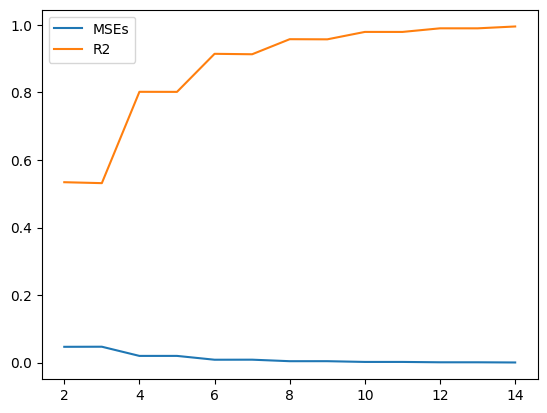

In [169]:
degrees = np.arange(2, 15, 1)
mses = np.zeros_like(degrees, dtype=float)
R2s = np.zeros_like(degrees, dtype=float)

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()

for i, degree in enumerate(degrees):
    beta = generateFitOLS(x_train, y_train, degree)
    mses[i], R2s[i] = testFit(x_test, y_test, beta)
    
plt.plot(degrees, mses, label="MSEs")
plt.plot(degrees, R2s, label="R2")
plt.legend()
plt.show()

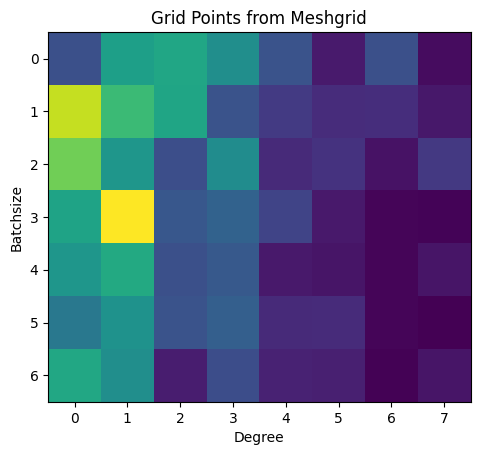

In [ ]:
mses = np.ndarray((7, 8))

for i, nData in enumerate(range(30, 100, 10)):
    x_train, x_test, y_train, y_test = generateData(nData)
    x_train = x_train.flatten(); x_test = x_test.flatten()
    for j, degree in enumerate(range(2, 10)):
        beta = generateFitOLS(x_train, y_train, degree)
        mses[i, j] = testFit(x_test, y_test, beta)
    
plt.imshow(mses)
plt.title("Grid Points from Meshgrid")
plt.xlabel("Degree")
plt.ylabel("Batchsize")
plt.show()

In [ ]:
def getRidgeParam(x : np.array, y : np.array, l : float) -> np.array:
    return np.linalg.inv(l*np.identity(x.shape[1]) + x.T @ x) @ x.T @ y

In [131]:
def generateFitRidge(xTrain : np.array, yTrain : np.array, degree : int, l : float) -> np.array:
    X = featureMat(xTrain, degree)
    return getRidgeParam(X, yTrain, l)

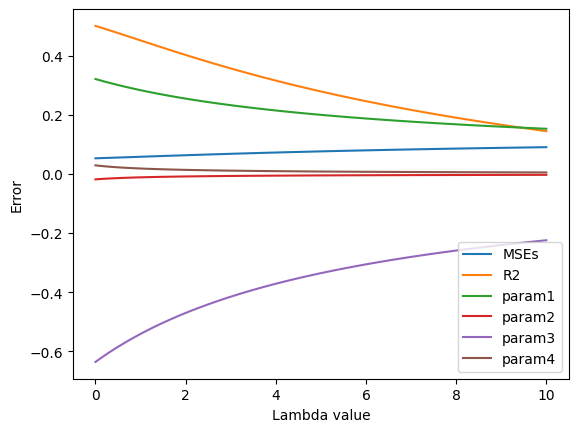

In [144]:
lambdas = np.linspace(0.001, 10, 100)
mses = np.zeros_like(lambdas, dtype=float)
R2s = np.zeros_like(lambdas, dtype=float)
thetas = []

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()

for i, l in enumerate(lambdas):
    beta = generateFitRidge(x_train, y_train, 3, l)
    thetas.append(beta)
    mses[i], R2s[i] = testFit(x_test, y_test, beta)
    
plt.plot(lambdas, mses, label="MSEs")
plt.plot(lambdas, R2s, label="R2")
plt.plot(lambdas, thetas, label=["param1", "param2", "param3", "param4"])
plt.xlabel("Lambda value")
plt.ylabel("Error")
plt.legend()
plt.show()

Task c)

In [160]:
class Grads():
    def __init__(self, n, X, y):
        self.temp1OLS = 2/n * X.T @ X
        self.temp2OLS = 2/n * X.T @ y
        self.temp1Ridge = 2/n * X.T @ X
        self.temp2Ridge = 2/n * X.T @ y

    def gOLS(self, theta): 
        return self.temp1OLS @ theta - self.temp2OLS


    def gRidge(self, theta, l):
        return self.temp1Ridge @ theta - self.temp2Ridge + 2*l*theta

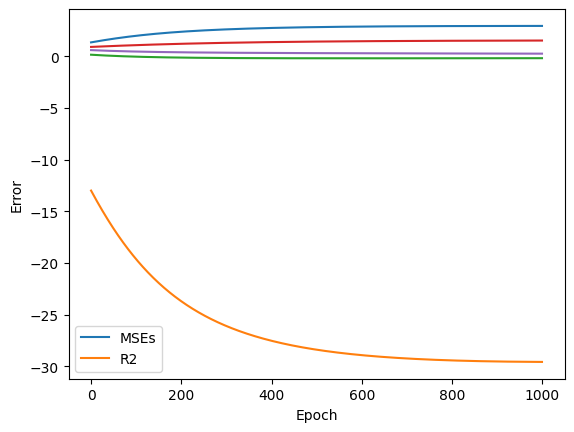

In [192]:
n_features = 3

# Gradient descent parameters, learning rate eta first
eta = 0.01
# Then number of iterations
epoch = 1000

# Initialize weights for gradient descent
theta = np.random.rand(n_features)

mses = np.ndarray(epoch)
R2s = np.ndarray(epoch)
thetas = []

nData = 100
x_train, x_test, y_train, y_test = generateData(nData)
x_train = x_train.flatten(); x_test = x_test.flatten()

grads = Grads(nData, featureMat(x_train, n_features, noIntercept=True), y_train)

# Gradient descent loop
for t in range(epoch):
    # Compute gradients for OSL and Ridge
    grad_OLS = grads.gOLS(theta)
    # Update parameters theta
    theta = theta - eta * grad_OLS

    thetas.append(theta)
    mses[t], R2s[t] = testFit(x_test, y_test, theta)

plt.plot(range(epoch), mses, label="MSEs")
plt.plot(range(epoch), R2s, label="R2")
plt.plot(range(epoch), thetas)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()